In [24]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data80084  eval.txt  ICL  readme.json  train.txt


In [25]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

checkpoints


In [26]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/9c/d8/909c4089dbe4ade9f9705f143c9f13f065049a9d5e7d34c828aefdd0a97c/beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/16/e3/4ad79882b92617e3a4a0df1960d6bce08edfb637737ac5c3f3ba29022e25/soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [27]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [28]:

import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset


In [29]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],#输入图片的shape
    "class_dim": -1,#分类数
    "src_path":"/home/aistudio/data/data80084/ICL Leaf dataset.zip",#原始数据集路径
    "target_path":"/home/aistudio/data/ICL/",#要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",#train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",#eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",#readme.json路径
    "label_dict":{},#标签字典
    "num_epochs": 25,#训练轮数
    "train_batch_size": 16,#训练时每个批次的大小
    "skip_steps": 10,
    "save_steps": 1000, 
    "learning_strategy": {#优化函数相关的配置
        "lr": 0.0001#超参数学习率
    },
    "checkpoints": "/home/aistudio/work/checkpoints"#保存的路径

}

In [30]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "ICL")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [31]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  +"/"+ class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:# 遍历文件夹下的每个图片
                if img_path == "Thumbs.db":
                    continue
                name_path = path + '/' + img_path# 每张图片的路径
                if class_sum % 8 == 0:# 每8张图片取一个做验证数据
                    eval_sum += 1# test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1#每类图片的数目
                all_class_images += 1 #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [32]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


In [33]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [34]:

#训练数据加载
train_dataset = dataset('/home/aistudio/data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [35]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/ICL//210/210 (41).jpg 	标签值 155
14657
文件名 /home/aistudio/data/ICL//114/114 (12).jpg 	标签值 46
2191
(3, 224, 224)
(1,)


In [36]:
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,#1
                 num_filters, #2
                 filter_size,#3
                 pool_size,#4
                 pool_stride,#5
                 groups,#6
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  
        self._conv2d_list = []

        for i in range(groups):
            conv2d = self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            num_channels = num_filters
            
            self._conv2d_list.append(conv2d)

        self._pool2d = paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        print(self._conv2d_list)





    def forward(self, inputs):
      x = inputs
      for conv in self._conv2d_list:
         x = conv(x)
         x = paddle.nn.functional.relu(x)
      x = self._pool2d(x)
      return x
      

In [37]:
class VGGNet(paddle.nn.Layer):
  
    def __init__(self):
        super(VGGNet, self).__init__()       
        self.convpool01 = ConvPool(
            3, 64, 3, 2, 2, 2)  #3:通道数，64：卷积核个数，3:卷积核大小，2:池化核大小，2:池化步长，2:连续卷积个数
        self.convpool02 = ConvPool(
            64, 128, 3, 2, 2, 2)
        self.convpool03 = ConvPool(
            128, 256, 3, 2, 2, 3) 
        self.convpool04 = ConvPool(
            256, 512, 3, 2, 2, 3)
        self.convpool05 = ConvPool(
            512, 512, 3, 2, 2, 3)       
        self.pool_5_shape = 512 * 7* 7
        self.fc01 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.fc02 = paddle.nn.Linear(4096, 4096)
        self.fc03 = paddle.nn.Linear(4096, train_parameters['class_dim'])

    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.convpool01(inputs)
        # print('convpool01_shape:', out.shape)           #[8, 64, 112, 112]
        out = self.convpool02(out)
        # print('convpool02_shape:', out.shape)           #[8, 128, 56, 56]
        out = self.convpool03(out)
        # print('convpool03_shape:', out.shape)           #[8, 256, 28, 28]
        out = self.convpool04(out)
        # print('convpool04_shape:', out.shape)           #[8, 512, 14, 14]
        out = self.convpool05(out)
        # print('convpool05_shape:', out.shape)           #[8, 512, 7, 7]         

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc01(out)
        out = self.fc02(out)
        out = self.fc03(out)
        
        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out
            

In [38]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
print(train_parameters['class_dim'])
print(train_parameters['label_dict'])

220
{'0': '129', '1': '103', '2': '118', '3': '190', '4': '086', '5': '185', '6': '060', '7': '054', '8': '073', '9': '064', '10': '113', '11': '083', '12': '140', '13': '007', '14': '009', '15': '207', '16': '194', '17': '202', '18': '174', '19': '144', '20': '076', '21': '192', '22': '029', '23': '034', '24': '080', '25': '217', '26': '095', '27': '065', '28': '130', '29': '181', '30': '070', '31': '085', '32': '208', '33': '141', '34': '151', '35': '088', '36': '126', '37': '096', '38': '059', '39': '090', '40': '137', '41': '156', '42': '184', '43': '108', '44': '005', '45': '041', '46': '114', '47': '166', '48': '121', '49': '199', '50': '094', '51': '134', '52': '183', '53': '175', '54': '069', '55': '084', '56': '024', '57': '117', '58': '010', '59': '216', '60': '139', '61': '058', '62': '163', '63': '167', '64': '092', '65': '044', '66': '105', '67': '098', '68': '051', '69': '110', '70': '102', '71': '196', '72': '087', '73': '033', '74': '214', '75': '074', '76': '063', '77'

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


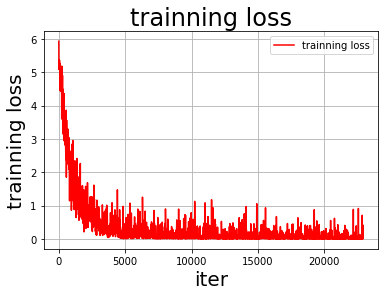

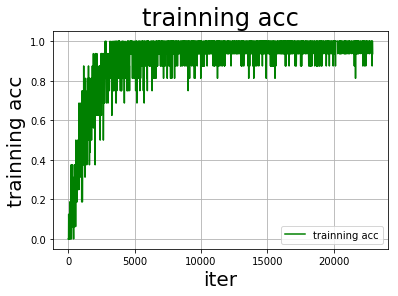

In [40]:

model = VGGNet()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data, y_data)
        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + "100" + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

In [41]:

'''
模型预测
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VGGNet()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []

for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

[Conv2D(3, 64, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(64, 128, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(128, 128, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(128, 256, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(256, 256, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(256, 256, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(256, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)]
模型在验证集上的准确率为： 0.7978363


In [42]:
import os

def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img

infer_dst_path = '/home/aistudio/data/'


In [47]:

model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_predict = VGGNet()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
infer_dst_path = "/home/aistudio/data"
infer_imgs_path = os.listdir(infer_dst_path+"/ICL/177/")
print(infer_imgs_path)
for infer_img_path in infer_imgs_path:
    if infer_img_path != "Thumbs.db":
        infer_img = load_image(infer_dst_path+"/ICL/177/"+infer_img_path)
        infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
        infer_img = paddle.to_tensor(infer_img)
        result = model_predict(infer_img)
        lab = np.argmax(result.numpy())
        if lab == 179:
            print("样本: {},预测结果为:{}".format(infer_img_path,"准确"))
        else:
            print("样本: {},预测结果为:{}".format(infer_img_path,"错误"))

[Conv2D(3, 64, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(64, 128, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(128, 128, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(128, 256, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(256, 256, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(256, 256, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(256, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)]
[Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW), Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)]
['177 (29).jpg', '177 (44).jpg', '177 (16).jpg', '177 (7).jpg', '177 (36).jpg', '177 (34).jpg', '177 (5).jpg', '177 (19).jpg', '17